# 1) Bigrams & Trigrams (Frequency & Comparison)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Compute and compare frequent bigrams and trigrams from two works by the same author. All examples are running on Alice in wonderland and Alice through the looking glass books.
- Visualize both the most frequent phrases and those that are most distinctive for each work.

Learning objectives:
- Practice robust text preprocessing for Project Gutenberg texts (strip headers, normalize quotes, fix hyphenation). You should be able to modify these cleaning steps for your own use cases.
- Generate n-grams, compute normalized rates, and compare phrase distributions across texts.
- Produce reproducible CSV and PNG artifacts under `../results/` for reports or slides later.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words like "the" or "and".
3. Run cells from top to bottom. The main outputs are saved to `../results/`.

Prerequisites:
- A Python environment with requirements.txt requirements installed.
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook normalizes curly quotes and prunes single-letter tokens (except `a` and `i`) to avoid spurious n-grams like `alice q s`.
- If you see unexpected tokens, inspect where they are coming from in the raw text with some inspection cells and find your own solution to tackle the issue.

**Goal:** Compute frequent **bigrams** and **trigrams** for your two selected works, compare across books, and visualize the most characteristic phrases.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.
- Results are saved under `../results/`.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": True,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20,                      # top items to show
    "rate_base": 10000               # per-N tokens for normalized rates
}

# Unicode-aware token regex: words with optional internal ' or -
# Keeps contractions (e.g., don't) and hyphenated compounds (e.g., well-known);
# intentionally excludes digits and underscores.
# Allow both ASCII apostrophe (') and common curly apostrophe (’) inside tokens
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'\u2019][^\W\d_]+)*", flags=re.UNICODE)


# Use spaCy English stop words (preferred for English-only runs).
# This does not require downloading a language model; spaCy exposes a built-in
# stop word set under spacy.lang.en.stop_words. If spaCy is not installed,
# fall back to a small built-in set so the notebook still runs offline.
try:
    import spacy
    from spacy.lang.en.stop_words import STOP_WORDS as _spacy_stop
    STOPWORDS = {w.lower() for w in _spacy_stop}
    stop_source = 'spacy'
except Exception:
    # spaCy not available; use a conservative built-in set to keep things running
    STOPWORDS = {
        'the','and','to','of','a','in','it','is','that','i','you','he','she',
        'they','we','was','for','on','with','as','at','by','an'
    }
# Merge optional extras from CONFIG and sensible fiction defaults (lowercased)
EXTRA = set(CONFIG.get('extra_stopwords', []))
EXTRA = {x.lower() for x in EXTRA}
EXTRA |= {'said'}
STOPWORDS |= EXTRA


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.

    Usage: call `strip_gutenberg(text)` before tokenization to remove header/footer noise.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [3]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    # This removes license text and front/back matter that would otherwise pollute counts.
    t = strip_gutenberg(t)
    # 1.5) Normalize smart/curly apostrophes to ASCII apostrophe so contractions
    # (e.g., don’t) are preserved as single tokens rather than split into
    # two tokens (don t). This handles U+2019 (right single quotation mark) and
    # U+2018 (left single quotation mark) commonly found in some texts/encodings.
    t = t.replace("’", "'")
    t = t.replace("‘", "'")
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())
tokens3 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]
    tokens3 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2 + tokens3

len(tokens1), len(tokens2), len(tokens)

(74994, 62625, 200244)

In [4]:
# Prune single-letter tokens except 'a' and 'i' to remove initials/artifacts
# This prevents spurious n-grams like 'alice q s' coming from sequences such as 'Q.'s' or 'Q.’s'.
keep_small = {'a', 'i'}
tokens1 = [t for t in tokens1 if (len(t) > 1) or (t in keep_small)]
tokens2 = [t for t in tokens2 if (len(t) > 1) or (t in keep_small)]
tokens3 = [t for t in tokens3 if (len(t) > 1) or (t in keep_small)]
# Recompute combined token sequence used elsewhere
tokens = tokens1 + tokens2 + tokens3
print('Lengths after prune: book1=', len(tokens1), 'book2=', len(tokens2), 'book3=', len(tokens3), 'combined=', len(tokens))

Lengths after prune: book1= 74913 book2= 62545 book3= 62545 combined= 200003


## 2. Helpers: n-gram generation & tables

In [5]:
from itertools import tee, islice

def ngrams(seq, n=2):
    """Return an iterator of n-grams from sequence `seq`.

    Example: list(ngrams([1,2,3], n=2)) -> [(1,2),(2,3)]
    """
    iters = tee(seq, n)
    for i, it in enumerate(iters):
        next(islice(it, i, i), None)
    return zip(*iters)


def freq_table(tokens, n=2, min_count=1, rate_base=10000, top_k=20):
    """Compute n-gram frequencies and return a DataFrame of top items.

    Returns:
      - df: pandas DataFrame with columns ['ngram','count','rate_per_X']
      - ng: Counter of all n-grams
      - total: total number of n-grams observed

    The 'rate_per_X' column normalizes counts per `rate_base` tokens to compare
    across books of different lengths.
    """
    ng = Counter(ngrams(tokens, n))
    total = sum(ng.values())
    rows = []
    for gram, c in ng.items():
        if c >= min_count:
            rows.append({
                "ngram": " ".join(gram),
                "count": c,
                "rate_per_%d" % rate_base: (c / max(1, total)) * rate_base
            })
    df = pd.DataFrame(rows).sort_values(["count", "ngram"], ascending=[False, True]).head(top_k)
    return df, ng, total


## 3. Bigram Frequency (Combined & Per Book)

In [6]:
min_c = CONFIG["min_ngram_count"]
top_k = CONFIG["top_k"]
rate_base = CONFIG["rate_base"]

# Combined
bi_df, bi_counts, bi_total = freq_table(tokens, n=2, min_count=min_c, rate_base=rate_base, top_k=top_k)
# Book-level
bi_df_1, bi_counts_1, bi_total_1 = freq_table(tokens1, n=2, min_count=min_c, rate_base=rate_base, top_k=top_k)
bi_df_2, bi_counts_2, bi_total_2 = freq_table(tokens2, n=2, min_count=min_c, rate_base=rate_base, top_k=top_k)
bi_df_3, bi_counts_3, bi_total_3 = freq_table(tokens3, n=2, min_count=min_c, rate_base=rate_base, top_k=top_k)

bi_df.head(10)

,ngram,count,rate_per_10000
161,far away,176,8.799912
145,mr frodo,127,6.349937
18,long ago,114,5.699943
253,don't know,100,4.999950
124,minas tirith,98,4.899951
835,frodo sam,97,4.849952
166,old man,84,4.199958
341,merry pippin,71,3.549965
119,bag end,59,2.949971
12,great river,57,2.849972


### 3.1 Plot Top Bigrams (Combined)

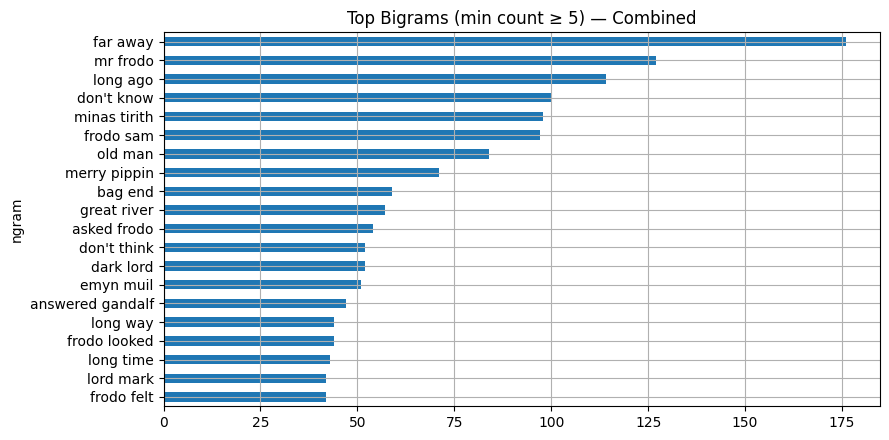

In [7]:
ax = bi_df.sort_values("count").plot.barh(x="ngram", y="count", legend=False)
ax.set_title(f"Top Bigrams (min count ≥ {min_c}) — Combined")
# Keep a reference to the Matplotlib Figure so we can save it later.
fig_combined = ax.get_figure()
plt.tight_layout(); plt.show()

### 3.2 Compare Distinctive Bigrams per Book

We compute **relative rates** and show items that are strong in one book relative to the other.


In [8]:
# Rename columns for each book
key = "rate_per_%d" % rate_base
df1 = bi_df_1.rename(columns={"count": "count_b1", key: "rate_b1"})
df2 = bi_df_2.rename(columns={"count": "count_b2", key: "rate_b2"})
df3 = bi_df_3.rename(columns={"count": "count_b3", key: "rate_b3"})

# Merge all three dataframes on 'ngram' with outer join
m = (df1[["ngram", "count_b1", "rate_b1"]]
     .merge(df2[["ngram", "count_b2", "rate_b2"]], on="ngram", how="outer")
     .merge(df3[["ngram", "count_b3", "rate_b3"]], on="ngram", how="outer")
     .fillna(0))

# === One-vs-Rest (OvR) Distinctiveness Scores ===
# For Book 1: rate_b1 - average(rate_b2, rate_b3)
m["dist_ovr_b1"] = m["rate_b1"] - (m["rate_b2"] + m["rate_b3"]) / 2

# For Book 2: rate_b2 - average(rate_b1, rate_b3)
m["dist_ovr_b2"] = m["rate_b2"] - (m["rate_b1"] + m["rate_b3"]) / 2

# For Book 3: rate_b3 - average(rate_b1, rate_b2)
m["dist_ovr_b3"] = m["rate_b3"] - (m["rate_b1"] + m["rate_b2"]) / 2

top_b1 = m.sort_values("dist_ovr_b1", ascending=False).head(top_k)
top_b2 = m.sort_values("dist_ovr_b2", ascending=False).head(top_k)
top_b3 = m.sort_values("dist_ovr_b3", ascending=False).head(top_k)



top_b1.head(10)

,ngram,count_b1,rate_b1,count_b2,rate_b2,count_b3,rate_b3,dist_ovr_b1,dist_ovr_b2,dist_ovr_b3
2,bag end,55.0,7.341948,0.0,0.000000,0.0,0.000000,7.341948,-3.670974,-3.670974
1,asked frodo,42.0,5.606578,0.0,0.000000,0.0,0.000000,5.606578,-2.803289,-2.803289
3,black riders,32.0,4.271679,0.0,0.000000,0.0,0.000000,4.271679,-2.135839,-2.135839
23,mr butterbur,29.0,3.871209,0.0,0.000000,0.0,0.000000,3.871209,-1.935604,-1.935604
10,frodo felt,28.0,3.737719,0.0,0.000000,0.0,0.000000,3.737719,-1.868859,-1.868859
11,frodo looked,26.0,3.470739,0.0,0.000000,0.0,0.000000,3.470739,-1.735370,-1.735370
4,cried frodo,25.0,3.337249,0.0,0.000000,0.0,0.000000,3.337249,-1.668625,-1.668625
28,tom bombadil,24.0,3.203759,0.0,0.000000,0.0,0.000000,3.203759,-1.601880,-1.601880
16,long ago,56.0,7.475438,29.0,4.636736,29.0,4.636736,2.838702,-1.419351,-1.419351
22,misty mountains,21.0,2.803289,0.0,0.000000,0.0,0.000000,2.803289,-1.401645,-1.401645


### 3.3 Visualize Distinctive Bigrams

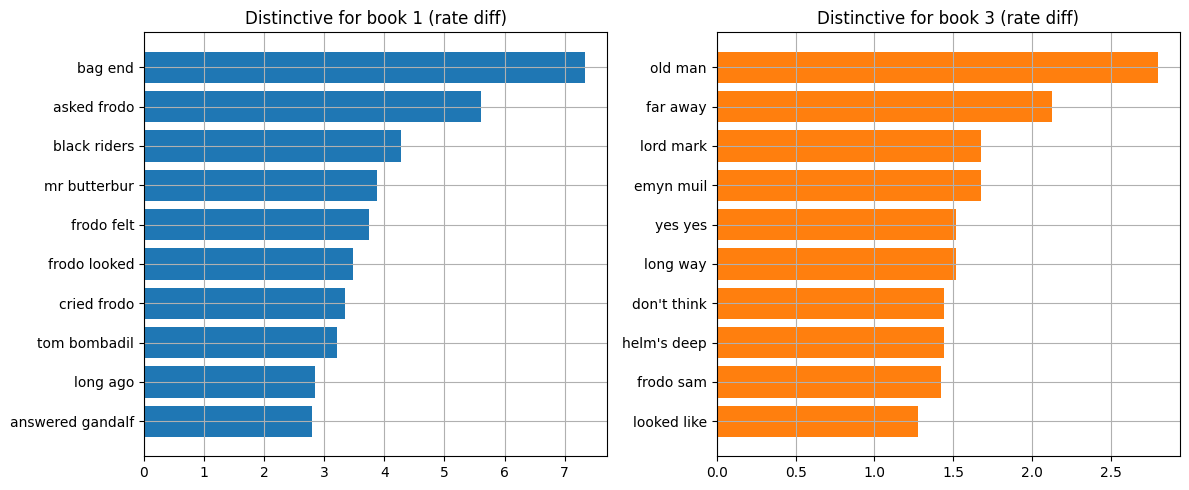

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=False)
top_b1_plot = top_b1.sort_values("dist_ovr_b1").tail(10)
axes[0].barh(top_b1_plot["ngram"], top_b1_plot["dist_ovr_b1"])
axes[0].set_title("Distinctive for book 1 (rate diff)")

top_b2_plot = top_b2.sort_values("dist_ovr_b2").tail(10)
axes[1].barh(top_b2_plot["ngram"], top_b2_plot["dist_ovr_b2"])
axes[1].set_title("Distinctive for book 2 (rate diff)")

top_b3_plot = top_b3.sort_values("dist_ovr_b3").tail(10)
axes[1].barh(top_b3_plot["ngram"], top_b3_plot["dist_ovr_b3"])
axes[1].set_title("Distinctive for book 3 (rate diff)")



# Save reference to this figure for later export.
fig_distinctive = fig

plt.tight_layout(); plt.show()

## 4. Trigram Frequency (Combined)

In [11]:
tri_df, tri_counts, tri_total = freq_table(tokens, n=3, min_count=min_c, rate_base=rate_base, top_k=top_k)
tri_df.head(10)

,ngram,count,rate_per_10000
14,aragorn son arathorn,24,1.199994
8,frodo son drogo,16,0.799996
33,théoden son thengel,14,0.699997
10,mr frodo sam,12,0.599997
2,old mr bilbo,12,0.599997
6,don't know frodo,10,0.499998
36,gimli son glóin,10,0.499998
47,wake mr frodo,10,0.499998
31,éomer son éomund,10,0.499998
1,drew deep breath,9,0.449998


## Optional N-grams

In [12]:
n_df, n_counts, n_total = freq_table(tokens, n=4, min_count=2, rate_base=rate_base, top_k=top_k)
n_df.head(10)

,ngram,count,rate_per_10000
55901,wake mr frodo wake,6,0.3
13914,bare bone war hew,4,0.2
21485,behold white rider cried,4,0.2
13915,bone war hew stone,4,0.2
12686,boom boom dahrar boom,4,0.2
13912,cold stone bare bone,4,0.2
40297,come mr frodo sam,4,0.2
13936,doom come doom come,4,0.2
29247,dozen ents came striding,4,0.2
54169,glare mordor died away,4,0.2


You can see that most of the longer Ngrams come from the "Jabberwocky" song in Alice's story.

### 4.1 Plot Top Trigrams (Combined)

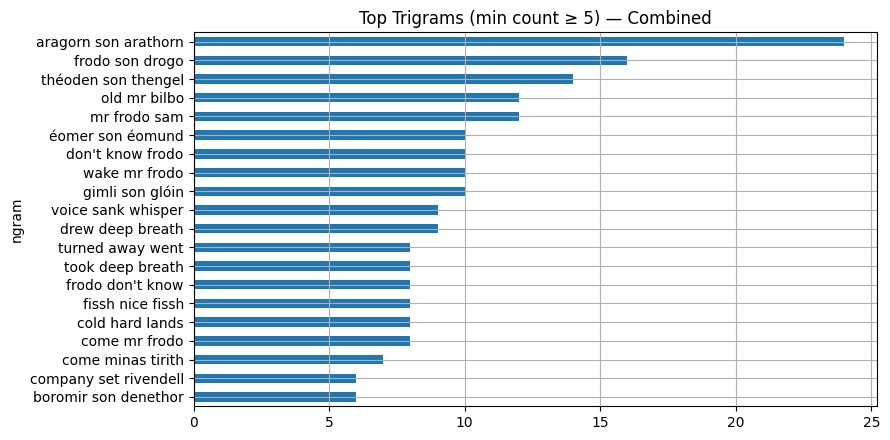

In [13]:
ax = tri_df.sort_values("count").plot.barh(x="ngram", y="count", legend=False)
ax.set_title(f"Top Trigrams (min count ≥ {min_c}) — Combined")
# Keep fig reference so we can save explicitly later
fig_tri = ax.get_figure()
plt.tight_layout(); plt.show()

## 5. Reflection

- Which bigrams/trigrams feel like your author’s “voice”?
- Are the most frequent items also the most **distinctive** across your two works?
- What changes when you toggle stopwords on/off?
- If character names dominate, consider removing them and re-running.


## 6. Export (tables/figures)

In [14]:
Path("../results").mkdir(exist_ok=True)

# Save data tables
bi_df.to_csv("../results/bigrams_combined.csv", index=False)
bi_df_1.to_csv("../results/bigrams_book1.csv", index=False)
bi_df_2.to_csv("../results/bigrams_book2.csv", index=False)
bi_df_3.to_csv("../results/bigrams_book3.csv", index=False)
tri_df.to_csv("../results/trigrams_combined.csv", index=False)

# Save figures explicitly by referencing the Figure objects we created earlier.
# This ensures we save the intended figures even after plt.show() was called.
try:
    fig_combined.savefig("../results/bigrams_plot.png", dpi=200, bbox_inches="tight")
except NameError:
    # fig_combined not defined (plot step may not have been executed)
    try:
        plt.savefig("../results/bigrams_plot.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass

# Distinctive plots
try:
    fig_distinctive.savefig("../results/distinctive_bigrams_plot.png", dpi=200, bbox_inches="tight")
except NameError:
    try:
        fig.savefig("../results/distinctive_bigrams_plot.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass

# Trigram figure
try:
    fig_tri.savefig("../results/trigrams_plot.png", dpi=200, bbox_inches="tight")
except NameError:
    try:
        # fallback to last active figure
        plt.savefig("../results/trigrams_plot.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass
